### This example demonstrates XCSF (single-step) reinforcement learning applied to the real-multiplexer problem. Classifiers are composed of hyperrectangle conditions, linear least squares predictions, and integer actions.

In [1]:
from __future__ import annotations

import random
from typing import Final

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import xcsf

### Create a real-multiplexer problem class

In [2]:
class Mux:
    """
    Real-multiplexer problem environment.

    The Mux class generates random real vectors of length k+pow(2,k) where the
    first k bits determine the position of the output bit in the last pow(2,k)
    bits. E.g., for a 3-bit problem, the first (rounded) bit addresses which of
    the following 2 bits are the (rounded) output.

    Example valid lengths: 3, 6, 11, 20, 37, 70, 135, 264.
    """

    def __init__(self, n_bits: int) -> None:
        """Constructs a new real-multiplexer problem of maximum size n_bits."""
        self.n_bits: Final[int] = n_bits  #: total number of bits
        self.n_actions: Final[int] = 2  #: total number of actions
        self.state: np.ndarray = np.zeros(n_bits)  #: current mux state
        self.max_payoff: Final[float] = 1  #: reward for a correct prediction
        self.pos_bits: int = 1  #: number of addressing bits
        while self.pos_bits + pow(2, self.pos_bits) <= self.n_bits:
            self.pos_bits += 1
        self.pos_bits -= 1
        print(f"{self.n_bits} bits, {self.pos_bits} position bits")

    def reset(self) -> None:
        """Generates a random real-multiplexer state."""
        for k in range(self.n_bits):
            self.state[k] = random.random()

    def answer(self) -> int:
        """Returns the (discretised) bit addressed by the current mux state."""
        pos: int = self.pos_bits
        for k in range(self.pos_bits):
            if self.state[k] > 0.5:
                pos += pow(2, self.pos_bits - 1 - k)
        if self.state[pos] > 0.5:
            return 1
        return 0

    def execute(self, act: int) -> float:
        """Returns the reward for performing an action."""
        if act == self.answer():
            return self.max_payoff
        return 0

In [3]:
### Instantiate a new real-multiplexer problem

In [4]:
mux: Mux = Mux(6)
X_DIM: Final[int] = mux.n_bits
N_ACTIONS: Final[int] = mux.n_actions
MAX_PAYOFF: Final[float] = mux.max_payoff

6 bits, 2 position bits


### Initialise XCSF

In [5]:
# constructor = (x_dim, y_dim, n_actions)
xcs: xcsf.XCS = xcsf.XCS(X_DIM, 1, N_ACTIONS)

xcs.OMP_NUM_THREADS = 8  # number of CPU cores to use
xcs.POP_SIZE = 1000  # maximum population size
xcs.E0 = 0.01  # target error
xcs.BETA = 0.2  # classifier parameter update rate
xcs.THETA_EA = 25  # EA frequency
xcs.ALPHA = 0.1  # accuracy offset
xcs.NU = 5  # accuracy slope
xcs.EA_SUBSUMPTION = True
xcs.SET_SUBSUMPTION = True
xcs.THETA_SUB = 100  # minimum experience of a subsumer
xcs.action("integer")
xcs.condition("hyperrectangle", {"min": 0, "max": 1, "spread_min": 0.1})
xcs.prediction("nlms_linear", {"eta": 1, "eta_min": 0.0001, "evolve_eta": True})

print(xcs.json_parameters())

{
	"version":	"1.1.6",
	"x_dim":	6,
	"y_dim":	1,
	"n_actions":	2,
	"omp_num_threads":	8,
	"pop_init":	true,
	"max_trials":	100000,
	"perf_trials":	1000,
	"pop_size":	1000,
	"loss_func":	"mae",
	"gamma":	0.95,
	"teletransportation":	50,
	"p_explore":	0.9,
	"set_subsumption":	true,
	"theta_sub":	100,
	"e0":	0.01,
	"alpha":	0.1,
	"nu":	5,
	"beta":	0.2,
	"delta":	0.1,
	"theta_del":	20,
	"init_fitness":	0.01,
	"init_error":	0,
	"m_probation":	10000,
	"stateful":	true,
	"compaction":	false,
	"ea":	{
		"select_type":	"roulette",
		"theta_ea":	25,
		"lambda":	2,
		"p_crossover":	0.8,
		"err_reduc":	1,
		"fit_reduc":	0.1,
		"subsumption":	true,
		"pred_reset":	false
	},
	"action":	{
		"type":	"integer"
	},
	"condition":	{
		"type":	"hyperrectangle",
		"args":	{
			"eta":	0,
			"min":	0,
			"max":	1,
			"spread_min":	0.1
		}
	},
	"prediction":	{
		"type":	"nlms_linear",
		"args":	{
			"x0":	1,
			"eta":	1,
			"evolve_eta":	true,
			"eta_min":	0.0001
		}
	}
}


### Execute experiment

In [6]:
PERF_TRIALS: Final[int] = 1000  # number of trials over which to average performance
N: Final[int] = 100  # 100,000 trials in total to run
trials: np.ndarray = np.zeros(N)
psize: np.ndarray = np.zeros(N)
msize: np.ndarray = np.zeros(N)
performance: np.ndarray = np.zeros(N)
error: np.ndarray = np.zeros(N)


def egreedy_action(state: np.ndarray, epsilon: float) -> tuple[int, float]:
    """Selects an action using an epsilon greedy policy."""
    if np.random.rand() < epsilon:
        return random.randrange(N_ACTIONS), 0
    prediction_array = xcs.predict(state.reshape(1, -1))[0]
    action = int(np.argmax(prediction_array))
    prediction = prediction_array[action]
    return action, prediction


def run_experiment() -> None:
    """Executes a single experiment."""
    bar = tqdm(total=N)  # progress bar
    for i in range(N):
        for _ in range(PERF_TRIALS):
            # explore trial
            mux.reset()
            action, prediction = egreedy_action(mux.state, 1)  # random action
            reward = mux.execute(action)
            xcs.fit(mux.state, action, reward)  # update action set, run EA, etc.
            # exploit trial
            mux.reset()
            action, prediction = egreedy_action(mux.state, 0)  # best action
            reward = mux.execute(action)
            performance[i] += reward / MAX_PAYOFF
            error[i] += abs(reward - prediction) / MAX_PAYOFF
        performance[i] /= float(PERF_TRIALS)
        error[i] /= PERF_TRIALS
        trials[i] = xcs.time()  # number of learning updates performed
        psize[i] = xcs.pset_size()  # current population size
        msize[i] = xcs.mset_size()  # avg match set size
        status = (  # update status
            f"trials={trials[i]:.0f} "
            f"performance={performance[i]:.5f} "
            f"error={error[i]:.5f} "
            f"psize={psize[i]:.1f} "
            f"msize={msize[i]:.1f}"
        )
        bar.set_description(status)
        bar.refresh()
        bar.update(1)
    bar.close()


run_experiment()

trials=100000 performance=0.99900 error=0.00852 psize=998.0 msize=99.5: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.46it/s]


### Plot XCSF learning performance

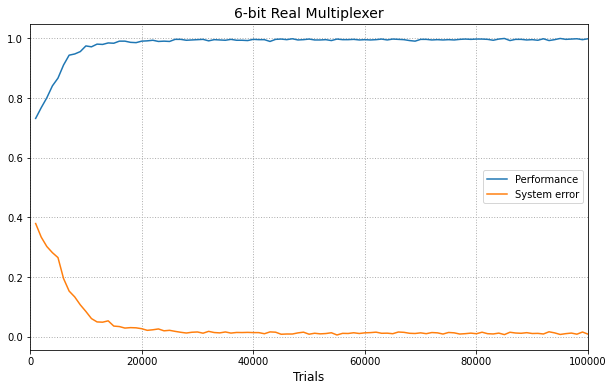

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(trials, performance, label="Performance")
plt.plot(trials, error, label="System error")
plt.grid(linestyle="dotted", linewidth=1)
plt.title(f"{mux.n_bits}-bit Real Multiplexer", fontsize=14)
plt.xlabel("Trials", fontsize=12)
plt.xlim([0, N * PERF_TRIALS])
plt.legend()
plt.show()